Conectando o Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Importando as Bibliotecas

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os

Confirmando o caminho das pastas Treino e Validação

In [3]:
base_dir = '/content/gdrive/MyDrive/meu_projeto/cats_dogs/dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

print(f"Confirmação do caminho do treino: {train_dir}")
print(f"Confirmação do caminho da validação: {validation_dir}")
print(f"Confirmação do caminho do teste: {test_dir}")

Confirmação do caminho do treino: /content/gdrive/MyDrive/meu_projeto/cats_dogs/dataset/train
Confirmação do caminho da validação: /content/gdrive/MyDrive/meu_projeto/cats_dogs/dataset/validation
Confirmação do caminho do teste: /content/gdrive/MyDrive/meu_projeto/cats_dogs/dataset/test


Configurando o VGG16 e o ImageDataGenerator

In [4]:
#Para o VGG16
img_width = 224
img_height = 224
batch_size = 32

#Para o Train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#Para a Validation
validation_datagen = ImageDataGenerator(rescale=1./255)

#Fluxo do train
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

#Fluxo do validation
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

#Fluxo do Teste
test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

#Confirmando o Mapeamento das classes
print("Confirmando o mapeamento das classes:", train_generator.class_indices)

Found 2023 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Confirmando o mapeamento das classes: {'cat': 0, 'dog': 1}


Carregando a Rede Neural e Construindo o Modelo do T.L.

In [5]:
#VGG16
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(img_width, img_height, 3))

#Congelando as camadas para impedir os pesos de atualizarem
conv_base.trainable = False

#Criando o Modelo
model = tf.keras.Sequential([
    conv_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

#Compilando o Modelo
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)
#Arquitetura do Modelo
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Treinando o Modelo

In [6]:
epochs = 15

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 651s 10s/step - accuracy: 0.6048 - loss: 0.6666 - val_accuracy: 0.8606 - val_loss: 0.3503
Epoch 2/15
 1/63 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.7500 - loss: 0.4677

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 0.7500 - loss: 0.4677 - val_accuracy: 0.8626 - val_loss: 0.3477
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 69s 759ms/step - accuracy: 0.7790 - loss: 0.4737 - val_accuracy: 0.8810 - val_loss: 0.2802
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.8125 - loss: 0.3679 - val_accuracy: 0.8943 - val_loss: 0.2727
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 70s 753ms/step - accuracy: 0.8157 - loss: 0.4088 - val_accuracy: 0.9087 - val_loss: 0.2343
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.8125 - loss: 0.3345 - val_accuracy: 0.9092 - val_loss: 0.2336
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 71s 760ms/step - accuracy: 0.8479 - loss: 0.3453 - val_accuracy: 0.9182 - val_loss: 0.2197
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.8125 - loss: 0.3729 - val_accuracy: 0.9127 - val_loss: 0.2205
Epoch 9/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 71s 764ms/step - accuracy: 0.8477 - loss: 0.3422 - val_accuracy: 0.919

Descongelando as camadas para otimizar o teste e evitar o overfitting.

In [9]:
conv_base.trainable = True

print("Total de camadas na base convolucional:", len(conv_base.layers))

for layer in conv_base.layers[:-4]:
    layer.trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

fine_tune_epochs = 5
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=total_epochs,
    initial_epoch=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Total de camadas na base convolucional: 19
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 831ms/step - accuracy: 0.8677 - loss: 0.3046 - val_accuracy: 0.9484 - val_loss: 0.1368
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - accuracy: 0.9062 - loss: 0.1996 - val_accuracy: 0.9459 - val_loss: 0.1382
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 775ms/step - accuracy: 0.9074 - loss: 0.2230 - val_accuracy: 0.9549 - val_loss: 0.1167
Epoch 19/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 0.9375 - loss: 0.2561 - val_accuracy: 0.9549 - val_loss: 0.1161
Epoch 20/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 71s 793ms/step - accuracy: 0.9107 - loss: 0.2165 - val_accuracy: 0.9370 - val_loss: 0.1590


Visualizando os Parametros do Treino e da Validação

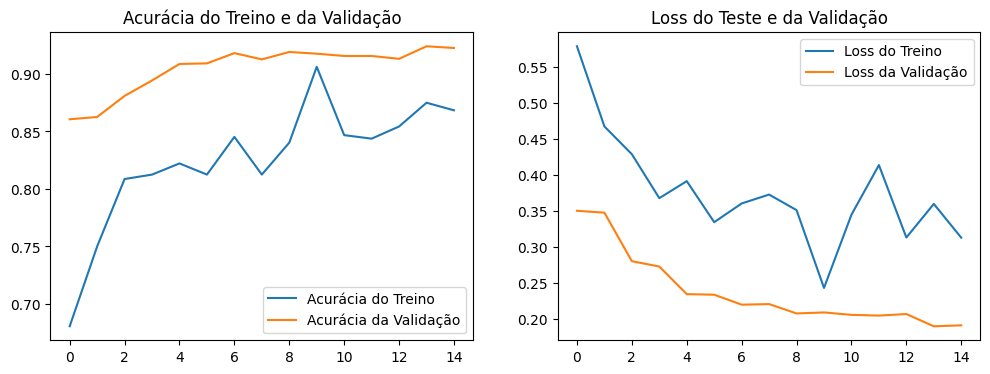

In [10]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Acurácia do Treino')
    plt.plot(epochs_range, val_acc, label='Acurácia da Validação')
    plt.legend(loc='lower right')
    plt.title('Acurácia do Treino e da Validação')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Loss do Treino')
    plt.plot(epochs_range, val_loss, label='Loss da Validação')
    plt.legend(loc='upper right')
    plt.title('Loss do Teste e da Validação')

    plt.show()

plot_history(history)

Avaliando o Modelo

In [11]:
test_loss, test_acc = model.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)


print(f"Acurácia do Teste: {test_acc:.4f}")
print(f"Loss do Teste: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.8955 - loss: 0.2606
Acurácia do Teste: 0.9370
Loss do Teste: 0.1587
